# Using up or downcast - hres : make gridded and plot

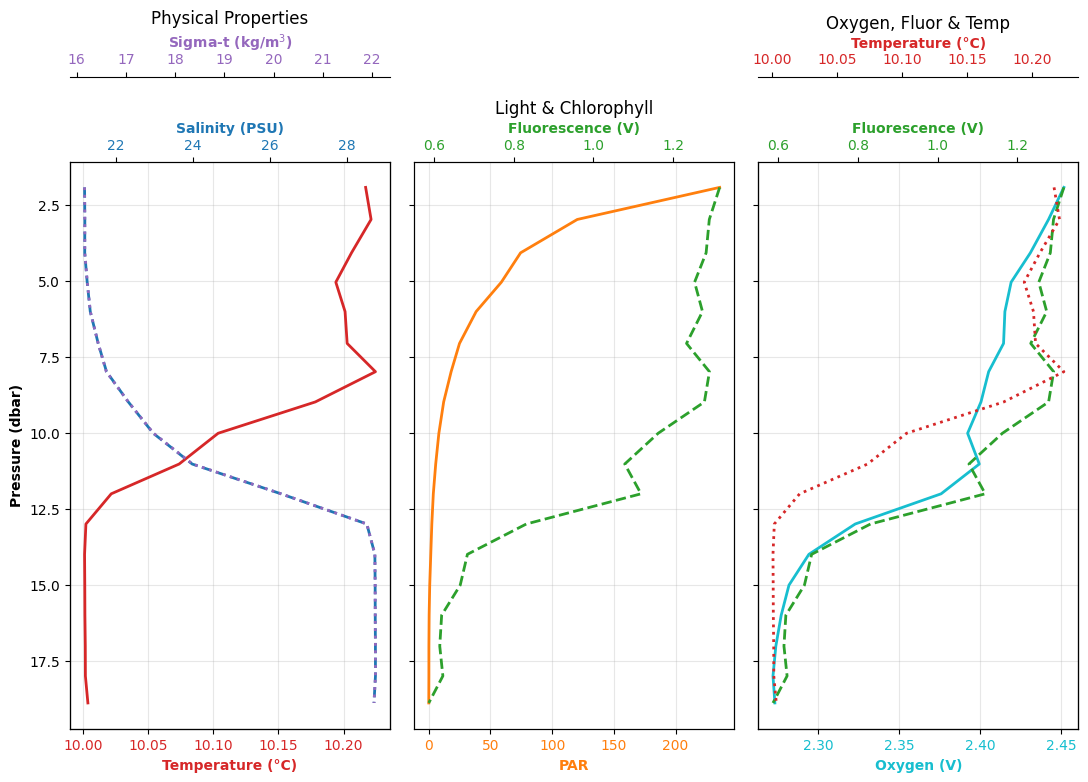

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

def bin_ctd_data(df: pd.DataFrame, 
                 bin_col: str = 'Pressure [dbar]', 
                 bin_size: int = 1) -> pd.DataFrame:
    """
    Bins CTD data into specified pressure intervals.
    
    Groups data by rounding the pressure column to the nearest multiple 
    of the bin_size (centering bins on integer values).

    Args:
        df: Input DataFrame containing CTD data.
        bin_col: Name of the pressure column.
        bin_size: Size of the bins in dbar.

    Returns:
        pd.DataFrame: Binned and averaged DataFrame.
    """
    # Create a copy to avoid side effects
    df_binned = df.copy()
    
    # Calculate bin index
    df_binned['bin_index'] = (df_binned[bin_col] / bin_size).round() * bin_size
    df_binned['bin_index'] = df_binned['bin_index'].astype(int)

    # Separate numeric and non-numeric columns
    numeric_cols = df_binned.select_dtypes(include=[np.number]).columns.tolist()
    if 'bin_index' in numeric_cols: 
        numeric_cols.remove('bin_index')
        
    non_numeric_cols = df_binned.select_dtypes(exclude=[np.number]).columns.tolist()

    # Define aggregation strategy
    agg_dict = {col: 'mean' for col in numeric_cols}
    agg_dict.update({col: 'first' for col in non_numeric_cols})
    
    # Group and aggregate
    return df_binned.groupby('bin_index').agg(agg_dict).sort_index()

def pss78_salinity(C: np.ndarray, T: np.ndarray, P: np.ndarray) -> np.ndarray:
    """
    Calculates Practical Salinity using the PSS-78 algorithm (Fofonoff & Millard 1983).
    
    Args:
        C: Conductivity in mS/cm.
        T: Temperature in °C (ITS-90).
        P: Pressure in dbar.
        
    Returns:
        np.ndarray: Practical Salinity (PSU).
    """
    C, T, P = np.asarray(C), np.asarray(T), np.asarray(P)
    
    # Constants
    a0, a1, a2, a3, a4, a5 = 0.0080, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081
    b0, b1, b2, b3, b4, b5 = 0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144
    c0, c1, c2, c3, c4 = 0.6766097, 2.00564e-2, 1.104259e-4, -6.9698e-7, 1.0031e-9
    d1, d2, d3, d4 = 3.426e-2, 4.464e-4, 4.215e-1, -3.107e-3
    e1, e2, e3 = 2.070e-5, -6.370e-10, 3.989e-15
    k = 0.0162
    
    # Convert ITS-90 to IPTS-68
    T68 = T * 1.00024
    
    # Conductivity Ratio R
    R = C / 42.914
    
    # rt: Ratio of conductivity at T to conductivity at 15C (P=0)
    rt = c0 + (c1 * T68) + (c2 * T68**2) + (c3 * T68**3) + (c4 * T68**4)
    
    # Rp: Ratio of conductivity at P to conductivity at P=0
    num = P * (e1 + e2 * P + e3 * P**2)
    den = 1 + d1 * T68 + d2 * T68**2 + (d3 + d4 * T68) * R
    Rp = 1 + num / den
    
    # Rt: Ratio of conductivity at T,P to conductivity at 15C,0
    Rt = R / (Rp * rt)
    Rt = np.maximum(Rt, 0) # Handle potential negative roots
    Rtx = np.sqrt(Rt)
    
    # Calculate Salinity
    S_uncorr = a0 + (a1 * Rtx) + (a2 * Rt) + (a3 * Rtx**3) + (a4 * Rt**2) + (a5 * Rtx**5)
    dS = ((T68 - 15) / (1 + k * (T68 - 15))) * (b0 + (b1 * Rtx) + (b2 * Rt) + (b3 * Rtx**3) + (b4 * Rt**2) + (b5 * Rtx**5))
    
    return S_uncorr + dS

def calculate_sigma_t(S: np.ndarray, T: np.ndarray) -> np.ndarray:
    """
    Calculates Sigma-t (density anomaly at surface pressure) using EOS-80.
    
    Args:
        S: Salinity (PSS-78).
        T: Temperature in °C (ITS-90).
    
    Returns:
        np.ndarray: Sigma-t (kg/m^3).
    """
    S, T = np.asarray(S), np.asarray(T)
    T = T * 1.00024 # Convert ITS-90 to IPTS-68
    
    # Density of pure water (Millero and Poisson 1981)
    kw = 999.842594
    c = [6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6, 6.536332e-9]
    rho_w = kw + sum(ci * T**(i+1) for i, ci in enumerate(c))
    
    # Salinity terms
    A = 8.24493e-1 - 4.0899e-3*T + 7.6438e-5*T**2 - 8.2467e-7*T**3 + 5.3875e-9*T**4
    B = -5.72466e-3 + 1.0227e-4*T - 1.6546e-6*T**2
    C = 4.8314e-4
    
    rho = rho_w + (A * S) + (B * S**1.5) + (C * S**2)
    return rho - 1000.0

def plot_three_panel_profile(df: pd.DataFrame, filename: str = 'three_panel_profile.png'):
    """Generates a 3-panel oceanographic profile."""
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 8), sharey=True)

    # --- Panel 1: Physics (Temp, Salinity, Sigma-t) ---
    # Temperature (Bottom)
    c_temp = 'tab:red'
    ax1.set_xlabel('Temperature (°C)', color=c_temp, fontweight='bold')
    ax1.plot(df['t090C'], df['Pressure [dbar]'], color=c_temp, linewidth=2)
    ax1.tick_params(axis='x', labelcolor=c_temp)
    ax1.set_ylabel('Pressure (dbar)', fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Physical Properties')

    # Salinity (Top)
    ax1_sal = ax1.twiny()
    c_sal = 'tab:blue'
    ax1_sal.set_xlabel('Salinity (PSU)', color=c_sal, fontweight='bold')
    ax1_sal.plot(df['Salinity'], df['Pressure [dbar]'], color=c_sal, linestyle='--', linewidth=2)
    ax1_sal.tick_params(axis='x', labelcolor=c_sal)

    # Sigma-t (Top Offset)
    ax1_sig = ax1.twiny()
    c_sig = 'tab:purple'
    ax1_sig.spines["top"].set_position(("axes", 1.15)) 
    ax1_sig.set_xlabel('Sigma-t (kg/m$^3$)', color=c_sig, fontweight='bold')
    ax1_sig.plot(df['Sigma_t'], df['Pressure [dbar]'], color=c_sig, linestyle=':', linewidth=2)
    ax1_sig.tick_params(axis='x', labelcolor=c_sig)


    # --- Panel 2: Biology 1 (PAR, Fluorescence) ---
    # PAR (Bottom)
    c_par = 'tab:orange'
    ax2.set_xlabel('PAR', color=c_par, fontweight='bold')
    ax2.plot(df['par/sat/log'], df['Pressure [dbar]'], color=c_par, linewidth=2)
    ax2.tick_params(axis='x', labelcolor=c_par)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Light & Chlorophyll')

    # Fluorescence (Top)
    ax2_fl = ax2.twiny()
    c_fl = 'tab:green'
    ax2_fl.set_xlabel('Fluorescence (V)', color=c_fl, fontweight='bold')
    ax2_fl.plot(df['flECO-AFL'], df['Pressure [dbar]'], color=c_fl, linestyle='--', linewidth=2)
    ax2_fl.tick_params(axis='x', labelcolor=c_fl)


    # --- Panel 3: Correlations (Oxygen, Fluor, Temp) ---
    # Oxygen (Bottom)
    c_ox = 'tab:cyan'
    ax3.set_xlabel('Oxygen (V)', color=c_ox, fontweight='bold')
    ax3.plot(df['sbeox0V'], df['Pressure [dbar]'], color=c_ox, linewidth=2)
    ax3.tick_params(axis='x', labelcolor=c_ox)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Oxygen, Fluor & Temp')

    # Fluorescence (Top)
    ax3_fl = ax3.twiny()
    ax3_fl.set_xlabel('Fluorescence (V)', color=c_fl, fontweight='bold')
    ax3_fl.plot(df['flECO-AFL'], df['Pressure [dbar]'], color=c_fl, linestyle='--', linewidth=2)
    ax3_fl.tick_params(axis='x', labelcolor=c_fl)

    # Temperature (Top Offset)
    ax3_temp = ax3.twiny()
    ax3_temp.spines["top"].set_position(("axes", 1.15)) 
    ax3_temp.set_xlabel('Temperature (°C)', color=c_temp, fontweight='bold')
    ax3_temp.plot(df['t090C'], df['Pressure [dbar]'], color=c_temp, linestyle=':', linewidth=2)
    ax3_temp.tick_params(axis='x', labelcolor=c_temp)

    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load Data
    filename = "/Users/bell/ecoraid/2025/CTDcasts/nw2501/working/NW2501c045_ctd.to_edit.hres.csv"
    raw_df = pd.read_csv(filename)

    # 2. Bin Data
    df_binned = bin_ctd_data(raw_df, bin_size=1)

    # 3. Calculate Derived Variables
    df_binned['Salinity'] = pss78_salinity(
        df_binned['c0mS/cm'], 
        df_binned['t090C'], 
        df_binned['Pressure [dbar]']
    )
    
    df_binned['Sigma_t'] = calculate_sigma_t(
        df_binned['Salinity'], 
        df_binned['t090C']
    )

    # 4. Visualize
    plot_three_panel_profile(df_binned, 'combined_profiles_with_sigmat.png')

In [9]:
df_binned

,Pressure [dbar],c0mS/cm,c1mS/cm,flECO-AFL,sbeox0V,sbeox1V,t090C,t190C,par/sat/log,latitude,longitude,flag,time,profileid,Salinity,Sigma_t
bin_index,,,,,,,,,,,,,,,,
2,1.914141,24.310873,24.329428,1.316987,2.451841,3.308425,10.217014,10.213176,235.799859,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.186248,16.160235
3,2.970500,24.321060,24.322106,1.290950,2.442358,3.665767,10.221204,10.221054,120.362375,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.193225,16.165056
4,4.068857,24.309144,24.321626,1.282962,2.431138,3.858095,10.206152,10.208900,74.424048,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.190284,16.164922
5,5.036305,24.368657,24.333035,1.253988,2.419237,4.076188,10.194081,10.196915,58.825525,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.253930,16.216091
6,6.004394,24.457220,24.452196,1.273852,2.415376,4.201758,10.201194,10.202809,38.387576,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.334173,16.277414
7,7.052950,24.673601,24.647016,1.233762,2.414550,4.180347,10.202803,10.202730,24.914000,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.539977,16.437074
8,7.984073,24.912644,24.888360,1.291329,2.405339,3.750271,10.224568,10.224159,18.119098,0.0,0.0,True,2025-09-18 23:21:30,uctd045,21.755680,16.601526
9,8.979968,25.473885,25.381185,1.278652,2.400597,3.428913,10.178316,10.185232,12.071942,0.0,0.0,True,2025-09-18 23:21:30,uctd045,22.322184,17.048402
10,10.012161,26.096233,26.074132,1.162487,2.392329,3.271281,10.103574,10.103261,8.187384,0.0,0.0,True,2025-09-18 23:21:30,uctd045,22.968649,17.561750
